Anne Urai, CSHL, 2019

code for https://www.abstractsonline.com/pp8/#!/7883/presentation/46202

see also Reinagel et al. Frontiers for effects of CA water in rats.

In [1]:
# GENERAL THINGS FOR COMPUTING AND PLOTTING
import pandas as pd
import numpy as np
import os, sys, time
from datetime import datetime
from datetime import timedelta

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", context="talk")

# ibl specific things
import datajoint as dj
from ibl_pipeline import reference, subject, action, acquisition, data, behavior
from ibl_pipeline.analyses import behavior as behavioral_analyses

# set path for saving figures
figpath = 'figures' # put in the same folder, but add to .gitignore for now

Connecting anneurai@datajoint.internationalbrainlab.org:3306


# STUDY 1. effects of CA on water intake and weight
data collected by Ines Laranjeira and Fanny Cazettes, CCU

In [2]:
########### SUBJECTS ########### 

subj = subject.Subject * subject.SubjectLab * subject.SubjectProject & 'subject_project = "collab_citricacid"' & 'lab_name="mainenlab"'

########### WEIGHINGS ########### 

weight_with_date = action.Weighing.proj('weight', session_date='DATE(weighing_time)')
weight_date = (dj.U('subject_uuid', 'session_date') & weight_with_date) & 'session_date < "2018-10-24"'
baseline_date = (dj.U('subject_uuid', 'session_date') & weight_with_date) & 'session_date = "2018-09-24"'

avg_weight_date = weight_date.aggr(weight_with_date, avg_weight='AVG(weight)') 
avg_baseline_weight_date = baseline_date.aggr(weight_with_date, avg_weight = 'AVG(weight)')

b = subj * avg_weight_date 
bb = subj * avg_baseline_weight_date

weight_df = pd.DataFrame(b.fetch(as_dict=True))
#weight_df.tail(n=10)

baseline_df = pd.DataFrame(bb.fetch(as_dict=True))
#baseline_df.tail(n=10)

In [3]:
########### WEIGHINGS NORMALIZATION and ########### 
########### CONVERSION OF SESSION DATES INTO SESSION NUMBERS ########### 

baseline_date = datetime.toordinal(datetime(2018, 9, 24))
change_date = datetime.toordinal(datetime(2018, 10, 5)) 

# Citric acid 2% was given on the 4th of Oct but on that day there was a 5-min 
# free water session, so I the 5th of Oct is used, as it is more accurate to show the effect of the change in concentration

normalized_df = weight_df.copy()
subject_count = 0
for s in baseline_df['subject_uuid']:
    subject_count += 1
    entry = normalized_df['subject_uuid'] == s # outputs list of booleans - True for all entries of mouse s 
    
    weight_count = 0
    for d in entry:
        weight_count += 1
        if d == True:
            normalized_df['avg_weight'][weight_count-1] = normalized_df['avg_weight'][weight_count-1] / baseline_df['avg_weight'][subject_count-1]
            normalized_df['session_date'][weight_count-1]  = datetime.toordinal(normalized_df['session_date'][weight_count-1]) - baseline_date
            

########### CONDITIONS ########### 

# CTL = free water regime (control)
# CA = ad libitum citric acid water
# FA = fixed amount of water per day (600 uL per weekday and 1 mL per weekend)
# CA = calculated amount (40 uL/g/day)

# now, we want to map these onto the subject names
CTL = 'Free water'
CA = 'Citric Acid'
WD = 'Weight-based amount'
FA = 'Fixed amount'

condition_map = {'ZM_205':CTL, 'ZM_335':CTL, '6873':CTL, 'ZM_200':CTL, 
'6867': CA, '6869':CA, 'ZM_209':CA, '6872':CA, 'ZM_342':CA,
'ZM_202':FA, 'ZM_337':FA, 'ZM_206':FA, 'ZM_208':FA, 
'ZM_203':WD, 'ZM_210':WD, 'ZM_338':WD, '6870':WD}

normalized_df['condition'] = normalized_df.subject_nickname.map(condition_map)
#normalized_df.tail(n=10)
#weight_df['condition'] = weight_df.subject_nickname.map(condition_map)

/anaconda3/envs/djenv/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda3/envs/djenv/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


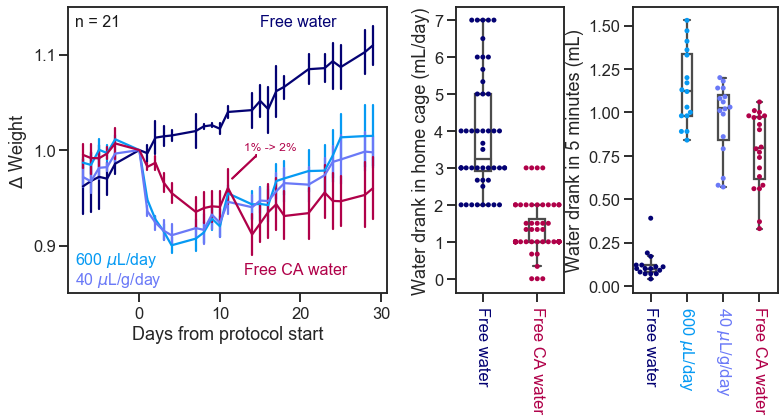

In [4]:
########### PLOTS ########### 
palette = sns.xkcd_palette(['deep blue', 'azure', 'cornflower', 'raspberry'])
hue_order = ['Free water', 'Fixed amount', 'Weight-based amount', 'Citric Acid']

f, ax = plt.subplots(ncols=3, nrows=1, gridspec_kw=dict(width_ratios=[2.2, 0.75, 1]), figsize=(11, 6))
    
sns.lineplot(x="session_date", y="avg_weight", err_style='bars', 
             ci=68, hue="condition", data=normalized_df, ax=ax[0], legend=False, 
            palette=palette, hue_order=hue_order)
ax[0].set_xlabel("Days from protocol start")    
ax[0].set_ylabel("$\Delta$ Weight")         
ax[0].set(ylim=[0.85, 1.15], yticks=[0.9, 1, 1.1])
ax[0].text(15, 1.13,'Free water', {'color':palette[0], 'fontsize':16})
ax[0].text(-8, 0.88,'600 $\mu$L/day', {'color':palette[1], 'fontsize':16})
ax[0].text(-8, 0.86,'40 $\mu$L/g/day', {'color':palette[2], 'fontsize':16})
ax[0].text(13, 0.87,'Free CA water', {'color':palette[3], 'fontsize':16})
ax[0].text(13, 1,'1% -> 2%', {'color':palette[3], 'fontsize':12})
ax[0].text(-8, 1.13, 'n = 21', {'color':'k', 'fontsize':16})
ax[0].arrow(11.5, 0.97, 3, 0.024, color=palette[3])

########### WATER ADMINISTRATIONS ########### 
water_with_date = (action.WaterAdministration & subj).proj('watertype_name', 'water_administered', 'adlib', # it can restrict on the subj here but it will anyway do later
                                                  session_date='DATE(administration_time)')
water_date = (dj.U('subject_uuid', 'session_date') & water_with_date) & 'session_date < "2018-10-24"'& 'session_date > "2018-10-05"'
total_water_date = water_date.aggr(water_with_date, total_water='SUM(water_administered)', 
                                   watertype="GROUP_CONCAT(DISTINCT watertype_name SEPARATOR '; ')", 
                                   adlib='MAX(adlib)')
b = subj * total_water_date # including water will exclude mice with ad lib water
df = pd.DataFrame(b.fetch(as_dict=True))

########### CONDITIONS ########### 

# CTL = free water regime (control)
# CA = ad libitum citric acid water
# FA = fixed amount of water per day (600 uL per weekday and 1 mL per weekend)
# CA = calculated amount (40 uL/g/day)

CA = 'Citric Acid'
WD = 'Weight-based amount'
FA = 'Fixed amount'
CTL = 'Free water'

condition_map = {'6867': CA, '6869':CA, 'ZM_209':CA, '6872':CA, 'ZM_342':CA,
'ZM_202':FA, 'ZM_337':FA, 'ZM_206':FA, 'ZM_208':FA, 
'ZM_203':WD, 'ZM_210':WD, 'ZM_338':WD, '6870':WD,
'ZM_205':CTL, 'ZM_335':CTL, '6873':CTL, 'ZM_200':CTL}

df['condition'] = df.subject_nickname.map(condition_map)

########### PLOTS ########### 
sns.swarmplot(x="condition", y="total_water", order=['Free water', 'Citric Acid'],  
              data=df, palette = sns.xkcd_palette(['deep blue', 'raspberry']), ax=ax[1])
sns.boxplot(x="condition", y="total_water", order=[ 'Free water', 'Citric Acid'], data=df, 
            fliersize=0, boxprops={'facecolor':'None'}, width=.3, ax=ax[1])
ax[1].set(ylabel='Water drank in home cage (mL/day)', xlabel='')
ax[1].set_xticklabels(['Free water', 'Free CA water'])


########### WATER ########### 
water= pd.read_csv('thirst.csv') # first date is exclude (habituation)

# MAP MICE ONTO DIFFERENT CONDITIONS
CA = 'Citric Acid'
WD = 'Weight-based amount'
FA = 'Fixed amount'
CTL = 'Free water'

condition_map = {'6867': CA, '6869':CA, 'ZM_209':CA, '6872':CA, 'ZM_342':CA,
'ZM_202':FA, 'ZM_337':FA, 'ZM_206':FA, 'ZM_208':FA, 
'ZM_203':WD, 'ZM_210':WD, 'ZM_338':WD, '6870':WD,
'ZM_205':CTL, 'ZM_335':CTL, '6873':CTL, 'ZM_200':CTL}

water['condition'] = water.subject.map(condition_map)

########### PLOTTING ########### 
sns.swarmplot(x="condition", y="water_amount", order=hue_order,  
              data=water, ax=ax[2], palette=palette)
sns.boxplot(x="condition", y="water_amount", order=hue_order, 
            data=water, fliersize=0, boxprops={'facecolor':'None'}, width=.3, ax=ax[2])
ax[2].set(ylabel='Water drank in 5 minutes (mL)', xlabel='')
ax[2].set_xticklabels(['Free water', '600 $\mu$L/day', '40 $\mu$L/g/day', 'Free CA water'])

# layout with rotated ticks
for ticklabel, tickcolor in zip(ax[1].get_xticklabels(), [palette[0], palette[3]]):
    ticklabel.set_color(tickcolor)
    ticklabel.set_rotation(-90)
    ticklabel.set(ha='center')
    
for ticklabel, tickcolor in zip(ax[2].get_xticklabels(), palette):
    ticklabel.set_color(tickcolor)
    ticklabel.set_rotation(-90)
    ticklabel.set(ha='center')
    
f.tight_layout()
f.savefig(os.path.join(figpath, "citricacid_study1.pdf"))
f.savefig(os.path.join(figpath, "citricacid_study1.png"), dpi=600)

# STUDY 2. effects of CA on task performance
data collected by Valeria Aguillon and Anne Urai, CSHL

In [5]:
# FIND THE DATA WE NEED
subj = (subject.Subject() & 'subject_birth_date < "2018-09-01"').proj('subject_nickname', 'sex') * \
    (subject.SubjectLab() & 'lab_name="churchlandlab"').proj()
print(subj)

# get date for each weighing
weight_with_date = action.Weighing.proj('weight', session_date='DATE(weighing_time)')
weight_date = (dj.U('subject_uuid', 'session_date') & weight_with_date)
avg_weight_date = weight_date.aggr(weight_with_date, avg_weight='AVG(weight)')

# NOW DO THE SAME FOR WATER
water_with_date = action.WaterAdministration.proj('watertype_name', 'water_administered', 'adlib',
                                                  session_date='DATE(administration_time)')
water_date = (dj.U('subject_uuid', 'session_date') & water_with_date)
# total_water_date = water_date.aggr(water_with_date, total_water='SUM(water_administered)', 
#                                    watertype="CONCAT_WS('; ', watertype_name)")
total_water_date = water_date.aggr(water_with_date, total_water='SUM(water_administered)', 
                                   watertype="GROUP_CONCAT(DISTINCT watertype_name SEPARATOR '; ')", 
                                   adlib='MAX(adlib)')
# get session with date
session_with_date = behavior.TrialSet.proj('n_trials') \
    * (acquisition.Session.proj(session_date='DATE(session_start_time)') & 'session_date > "2019-03-17"') \
    * behavioral_analyses.PsychResults()
b = subj * session_with_date * avg_weight_date * total_water_date
df = pd.DataFrame(b.fetch(as_dict=True))
#df.tail(n=10)

# ADD SOME MORE USEFUL INFO - group by week, from Saturday to Friday
df['session_date'] = pd.to_datetime(df.session_date)
df['week_number']  = df['session_date'].dt.week
df['weekday_name'] = df['session_date'].dt.day_name()
df['weekday']      = df['session_date'].dt.weekday

# THEN GIVE EVERY WEEK A CONDITION NAME!
#
# let's define 5 conditions
# O = one mL water in weekend, sucrose water in task
# C = citric acid water in weekend, sucrose water in task
# CC = citric acid water in weekend + week, sucrose water in task
# W = regular water in weekend, sucrose water in task
# WW = regular water in weekend + week, sucrose water in task
#
# now, we want to map these onto the week numbers
condition_map = {10:'CC', 11:'C', 12:'C', 13:'C', 14:'C', 15:'C', 16:'C', 
                 17:'CC', 18:'C', 19:'WW', 20:'O', 21:'C', 22:'C', 23:'C', 24:'C', 25:'WW',
                27:'CC', 28:'WW', 29:'O', 30:'CC', 31:'W', 32:'O', 33:'W', 34:'W', 36:'H', 37:'H', 38:'C', 39:'H'}

df['condition'] = df.week_number.map(condition_map)

# SHOW THIS, AND CHECK THAT IT'S CORRECT!
# sanitycheck = df.groupby(['week_number', 'condition', 'session_date', 'weekday_name'])['watertype'].unique()
# sanitycheck.to_csv(os.path.join(figpath, "check_water_conditions.csv"))

# redo the color mapping
condition_order = ["WW", "W", "O", "C", "H", "CC"]
palette = sns.xkcd_palette(['deep blue', 'electric blue', 'azure', 'purpley pink', 'dark lilac', 'raspberry'])
df.describe()
marker_mapping = {'WW':'<', 'W':'>', 'O':'o', 'C':'v', 'H':'P', 'CC':'^'}
condition_names = ['Free water', 'Free wknd water', '1mL/day', 'Free wknd CA water', 
                   'Free wknd CA hydrogel', 'Free CA water']

*subject_uuid  subject_nickna sex    
+------------+ +------------+ +-----+
034c07c5-69b0- IBL_25         M      
063bc242-80a7- IBL_16         M      
1208c089-8b8e- IBL_13         M      
1fce4668-e99f- IBL_36         M      
24ccb0ca-c7cb- IBL_17         M      
278bf922-073e- IBL_26         M      
34d5b181-e7c8- IBL_45         M      
3e97e1d3-2a0f- IBL_34         M      
3f854f88-7879- IBL_11         M      
50883573-cf52- IBL_47         M      
52a800fc-cbbc- IBL_1          M      
55381f61-4e47- IBL_46         M      
   ...
 (Total: 22)



In [6]:
# MAKE NICE-LOOKING DATE AXES
import matplotlib.dates as mdates
def fix_date_axis(ax):
    ax.xaxis_date()
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.SUNDAY))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
    for item in ax.get_xticklabels():
        item.set_rotation(-90)
        item.set(ha='center')


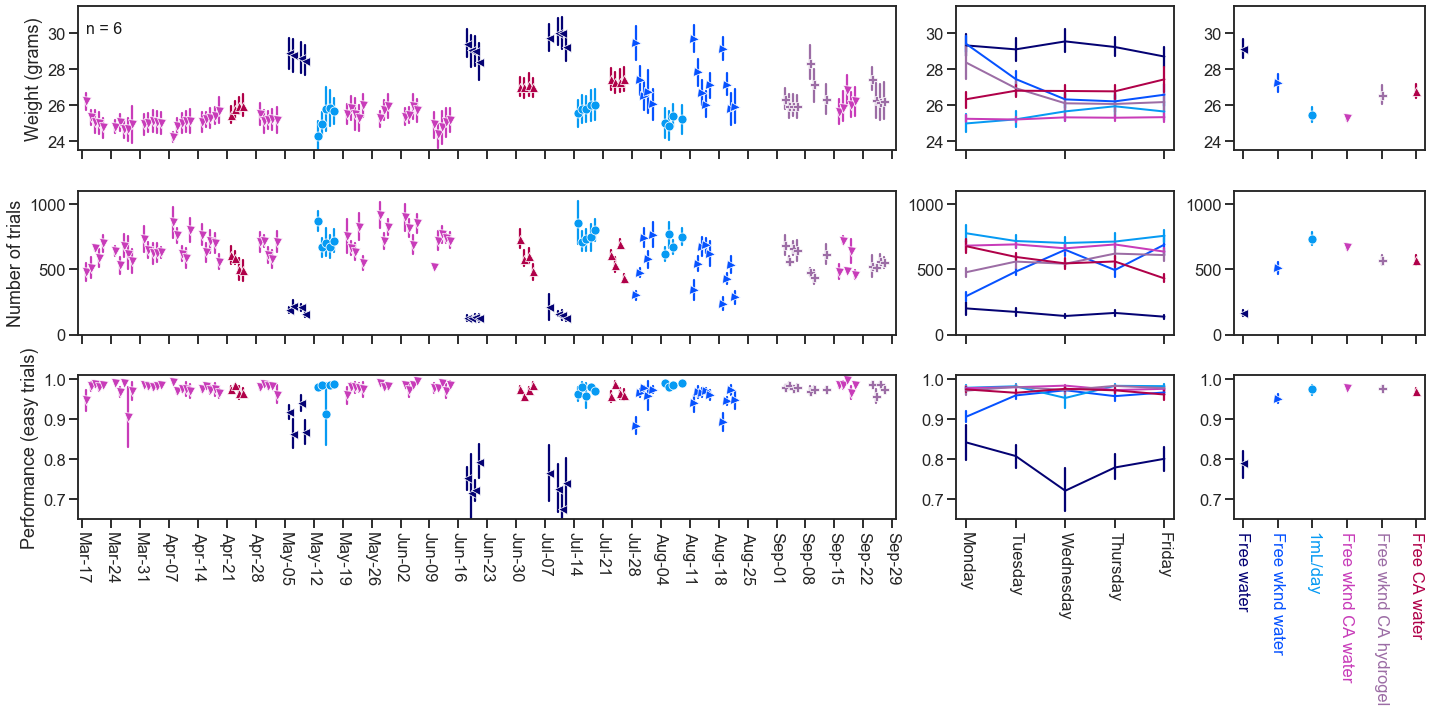

In [98]:
## NOW PLOT WITH SEABORN

f, ax = plt.subplots(ncols=3, nrows=3, 
                     gridspec_kw=dict(width_ratios=[3, 0.8, 0.7], height_ratios=[1,1,1]), figsize=(20, 10))
ylims_weight = [23.5, 31.5]
ylims_ntrials = [0, 1100]
ylims_performance = [0.65, 1.01]
xlims = [df.session_date.min()-timedelta(days=2), df.session_date.max()+timedelta(days=3)]

sns.lineplot(x="session_date", y="avg_weight", err_style='bars', ci=68, hue="condition", style='condition', markers=marker_mapping, 
             linewidth=0, data=df, ax=ax[0,0], legend=False, hue_order=condition_order, palette=palette)
ax[0,0].set(ylabel="Weight (grams)", ylim=ylims_weight, xlabel="", xlim=xlims)
ax[0,0].tick_params(labelbottom=False)    
ax[0,0].text(df.session_date.min(), 30, 'n = 6', {'color':'k', 'fontsize':16})
sns.lineplot(x="session_date", y="n_trials", err_style='bars', ci=68, hue="condition", style='condition', markers=marker_mapping,  
             linewidth=0, data=df, ax=ax[1,0], legend=False, hue_order=condition_order, palette=palette)
ax[1,0].set(ylabel="Number of trials", xlabel="", ylim=ylims_ntrials, xlim=xlims)
ax[1,0].tick_params(labelbottom=False)    
sns.lineplot(x="session_date", y="performance_easy", err_style='bars', ci=68, hue="condition",style='condition', markers=marker_mapping,  
             linewidth=0, data=df, ax=ax[2,0], legend=False, hue_order=condition_order, palette=palette)
ax[2,0].set(ylabel="Performance (easy trials)", xlabel="", ylim=ylims_performance, xlim=xlims)

# set grid to show Mondays
fix_date_axis(ax[0,0])
fix_date_axis(ax[1,0])
fix_date_axis(ax[2,0])

## SECOND COLUMN
sns.lineplot(x="weekday", y="avg_weight", err_style='bars', ci=68, hue="condition",
             linewidth=2, data=df, ax=ax[0,1], legend=False, hue_order=condition_order, palette=palette)
ax[0,1].set(ylabel="", ylim=ylims_weight, xlabel="")
ax[0,1].tick_params(labelbottom=False)    
sns.lineplot(x="weekday", y="n_trials", err_style='bars', ci=68, hue="condition",
             linewidth=2, data=df, ax=ax[1,1], legend=False, hue_order=condition_order, palette=palette)
ax[1,1].set(ylabel="", ylim=ylims_ntrials, xlabel="")
ax[1,1].tick_params(labelbottom=False)    
sns.lineplot(x="weekday", y="performance_easy", err_style='bars', ci=68, hue="condition",
             linewidth=2, data=df, ax=ax[2,1], legend=False, hue_order=condition_order, palette=palette)
ax[2,1].set(ylabel="", xticks=[0,1,2,3,4], 
          xticklabels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'], xlabel="", ylim=ylims_performance)

for item in ax[2,1].get_xticklabels():
    item.set_rotation(-90)
    item.set(ha='center')
    
## Third columns
sns.lineplot(x="condition", y="avg_weight", err_style='bars', style='condition', markers=marker_mapping, 
             ci=95, linewidth=2, hue_order=condition_order, palette=palette, hue="condition", data=df, ax=ax[0,2])
#sns.boxplot(x="condition", y="avg_weight", order=condition_order,data=df, fliersize=0, ax=ax[0,2], boxprops={'facecolor':'None'}, width=.3)
ax[0,2].set(ylabel="", xlabel="", ylim=ylims_weight)
ax[0,2].get_legend().remove()
ax[0,2].tick_params(labelbottom=False)    

sns.lineplot(x="condition", y="n_trials", err_style='bars', style='condition', markers=marker_mapping, 
             ci=95, linewidth=2, hue_order=condition_order, palette=palette, hue="condition", data=df, ax=ax[1,2])
#sns.boxplot(x="condition", y="n_trials", order=condition_order, data=df, fliersize=0, ax=ax[1,2], boxprops={'facecolor':'None'}, width=.3)
ax[1,2].set(ylabel="", xlabel="", ylim=ylims_ntrials)
ax[1,2].get_legend().remove()
ax[1,2].tick_params(labelbottom=False)    
sns.lineplot(x="condition", y="performance_easy", err_style='bars', style='condition', markers=marker_mapping, 
             ci=95, linewidth=2, hue_order=condition_order, palette=palette, hue="condition", data=df, ax=ax[2,2])
#sns.lineplot(x="condition", y="performance_easy", order=condition_order, data=df, fliersize=0, ax=ax[2,2], boxprops={'facecolor':'None'}, width=.3)
ax[2,2].set(ylabel="", xlabel="", ylim=ylims_performance)
ax[2,2].get_legend().remove()
ax[2,2].set_xticklabels(condition_names)

for ticklabel, tickcolor in zip(ax[2,2].get_xticklabels(), palette):
    ticklabel.set_color(tickcolor)
    ticklabel.set_rotation(-90)
    ticklabel.set(ha='center')

# SAVE
f.tight_layout()
f.savefig(os.path.join(figpath, "citricacid_study2.pdf"))
f.savefig(os.path.join(figpath, "citricacid_study2.png"), dpi=300)


# STUDY 2b. effects of CA in water vs Hydrogel
data collected by Valeria Aguillon and Anne Urai, CSHL
    

In [138]:
# FIND THE DATA WE NEED
# BATCH 4
batch4 = subject.Subject() & 'subject_nickname IN ("IBL_13", "IBL_14", "IBL_15", "IBL_16")'
b = batch4 * (avg_weight_date & 'session_date BETWEEN "2018-08-08" AND "2018-09-12"')
df_batch4 = pd.DataFrame(b.fetch(as_dict=True, order_by='subject_nickname, session_date'))
df_batch4['session_day'] = (df_batch4['session_date'] - df_batch4['session_date'].min()).dt.days

# map onto conditions
bins = [np.datetime64('2018-08-07'), np.datetime64('2018-08-11'), 
        np.datetime64('2018-08-17'), np.datetime64('2018-08-28'), np.datetime64('2018-09-11')]
names = [1, 2, 4, 6]
df_batch4['condition'] = pd.cut(df_batch4.session_date, bins, labels=names)

# baseline correct with the first two days
for index, group in df_batch4.groupby(['subject_nickname']):
      df_batch4['avg_weight'][df_batch4.index.isin(group.index)] =  group['avg_weight'] / group[group['condition'] == 1]['avg_weight'].values.mean()
        
        
###### the other batch
batch2 = subject.Subject() & 'subject_nickname IN ("IBL_18", "IBL_19", "IBL_20", "IBL_21", "IBL_22", "IBL_23", "IBL_24", "IBL_25", "IBL_26", "IBL_27")'
b = batch2 * (avg_weight_date & 'session_date BETWEEN "2018-08-20" AND "2018-10-04"')
df_batch2 = pd.DataFrame(b.fetch(as_dict=True))
df_batch2['session_day'] = (df_batch2['session_date'] - df_batch2['session_date'].min()).dt.days

# map onto conditions
bins = [np.datetime64('2018-08-08'), np.datetime64('2018-08-24'), 
        np.datetime64('2018-09-17'), np.datetime64('2018-10-03')]
names = [1, 6, 5]
df_batch2['condition'] = pd.cut(df_batch2.session_date, bins, labels=names)
df_batch2 = df_batch2[df_batch2.session_day != 12] # hack

# baseline correct with the first two days
for index, group in df_batch2.groupby(['subject_nickname']):
     df_batch2['avg_weight'][df_batch2.index.isin(group.index)] = group['avg_weight']/ group[group['condition'] == 1]['avg_weight'].values.mean()
        

/anaconda3/envs/djenv/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/anaconda3/envs/djenv/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


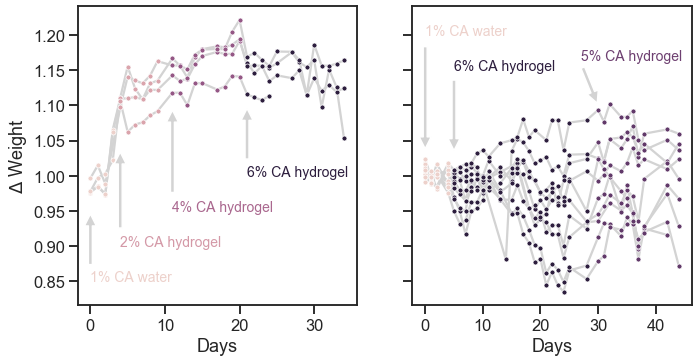

In [188]:
## PLOT #####

palette = sns.cubehelix_palette(5)

f, ax = plt.subplots(ncols=2, nrows=1, gridspec_kw=dict(width_ratios=[1,1]), figsize=(11, 5.5), sharey=True)
sns.lineplot(x="session_day", y="avg_weight",  units='subject_nickname', estimator=None, 
             data=df_batch4, ax=ax[0], legend=False, color='lightgrey')
sns.lineplot(x="session_day", y="avg_weight", hue='condition', marker='o', ms=5,
             linewidth=0, units='subject_nickname', estimator=None, err_style='bars', 
             data=df_batch4, ax=ax[0], legend=False)
ax[0].set_xlabel("Days")    
ax[0].set_ylabel("$\Delta$ Weight")         

ax[0].annotate('1% CA water', xy=(0, 0.95), xytext=(0, 0.85), color=palette[0], fontsize=14,
              arrowprops=dict(facecolor='lightgrey', shrink=0.05))
ax[0].annotate('2% CA hydrogel', xy=(4, 1.04), xytext=(4, 0.90), color=palette[1], fontsize=14,
              arrowprops=dict(facecolor='lightgrey', shrink=0.05))
ax[0].annotate('4% CA hydrogel', xy=(11, 1.1), xytext=(11, 0.95), color=palette[2], fontsize=14,
              arrowprops=dict(facecolor='lightgrey', shrink=0.05))
ax[0].annotate('6% CA hydrogel', xy=(21, 1.1), xytext=(21, 1), color=palette[4], fontsize=14,
              arrowprops=dict(facecolor='lightgrey', shrink=0.05))

sns.lineplot(x="session_day", y="avg_weight",  units='subject_nickname', estimator=None, 
             data=df_batch2, ax=ax[1], legend=False, color='lightgrey')
sns.lineplot(x="session_day", y="avg_weight", hue='condition', marker='o', ms=5,
             linewidth=0, units='subject_nickname', estimator=None, err_style='bars', 
             data=df_batch2, ax=ax[1], legend=False)
ax[1].set_xlabel("Days")    
ax[1].set_ylabel("$\Delta$ Weight")  

ax[1].annotate('1% CA water', xy=(0, 1.03), xytext=(0, 1.2), color=palette[0], fontsize=14,
              arrowprops=dict(facecolor='lightgrey', shrink=0.05))
ax[1].annotate('6% CA hydrogel', xy=(5, 1.03), xytext=(5, 1.15), color=palette[4], fontsize=14,
              arrowprops=dict(facecolor='lightgrey', shrink=0.05))
ax[1].annotate('5% CA hydrogel', xy=(30, 1.1), xytext=(27, 1.165), color=palette[3], fontsize=14,
              arrowprops=dict(facecolor='lightgrey', shrink=0.05))

# SAVE
#f.tight_layout()
f.savefig(os.path.join(figpath, "citricacid_study3.pdf"))
f.savefig(os.path.join(figpath, "citricacid_study3.png"), dpi=300)
